##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet                                                                                                                    # IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 迁移学习和微调

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/tutorials/images/transfer_learning"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a></td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/images/transfer_learning.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">Run in Google Colab</a>   </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/images/transfer_learning.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a> </td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/images/transfer_learning.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

在本教程中，您将学习如何使用迁移学习通过预训练网络对猫和狗的图像进行分类。

预训练模型是一个之前基于大型数据集（通常是大型图像分类任务）训练的已保存网络。您可以按原样使用预训练模型，也可以使用迁移学习针对给定任务自定义此模型。

用于图像分类的迁移学习背后的理念是，如果一个模型是基于足够大且通用的数据集训练的，那么该模型将有效地充当视觉世界的通用模型。随后，您可以利用这些学习到的特征映射，而不必通过基于大型数据集训练大型模型而从头开始。

在此笔记本中，您将尝试通过以下两种方式来自定义预训练模型：

1. 特征提取：使用先前网络学习的表示从新样本中提取有意义的特征。您只需在预训练模型上添加一个将从头开始训练的新分类器，这样便可重复利用先前针对数据集学习的特征映射。

您无需（重新）训练整个模型。基础卷积网络已经包含通常用于图片分类的特征。但是，预训练模型的最终分类部分特定于原始分类任务，随后特定于训练模型所使用的类集。

1. 微调：解冻已冻结模型库的一些顶层，并共同训练新添加的分类器层和基础模型的最后几层。这样，我们便能“微调”基础模型中的高阶特征表示，以使其与特定任务更相关。

您将遵循通用的机器学习工作流。

1. 检查并理解数据
2. 构建输入流水线，在本例中使用 Keras ImageDataGenerator
3. 构成模型
    - 加载预训练的基础模型（和预训练权重）
    - 将分类层堆叠在顶部
4. 训练模型
5. 评估模型


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## 数据预处理

### 数据下载

在本教程中，您将使用包含数千个猫和狗图像的数据集。下载并解压缩包含图像的 zip 文件，然后使用 `tf.keras.utils.image_dataset_from_directory` 效用函数创建一个 `tf.data.Dataset` 进行训练和验证。您可以在此[教程](https://tensorflow.google.cn/tutorials/load_data/images)中详细了解如何加载图像。

In [3]:
# _URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
# path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname('../data/'), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


显示训练集中的前九个图像和标签：

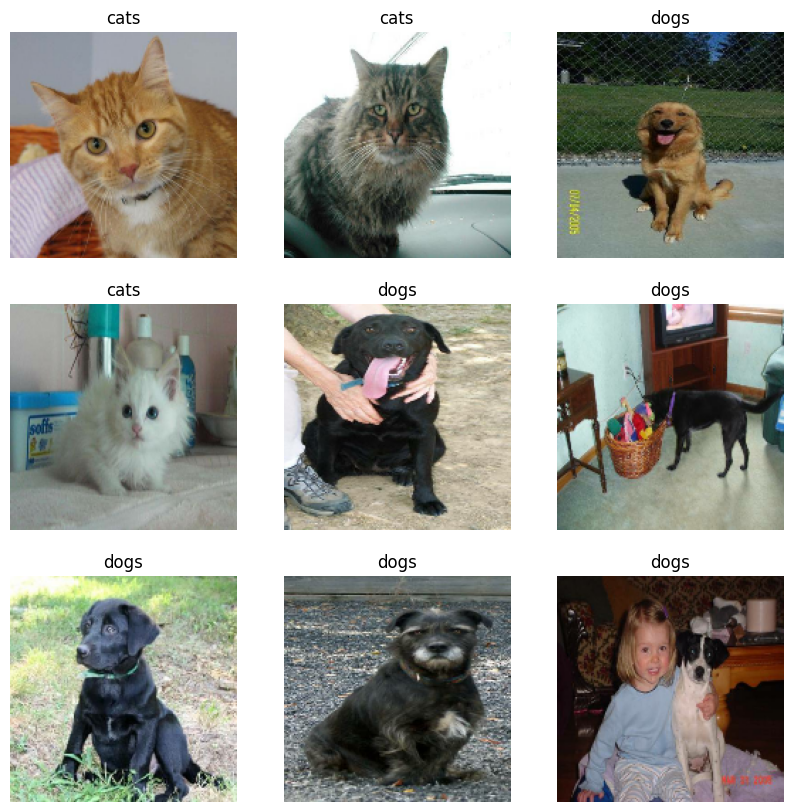

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

由于原始数据集不包含测试集，因此您需要创建一个。为此，请使用 `tf.data.experimental.cardinality` 确定验证集中有多少批次的数据，然后将其中的 20% 移至测试集。

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### 配置数据集以提高性能

使用缓冲预提取从磁盘加载图像，以免造成 I/O 阻塞。要详细了解这种方式，请参阅[数据性能](https://tensorflow.google.cn/guide/data_performance)指南。

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### 使用数据扩充

当您没有较大的图像数据集时，最好将随机但现实的转换应用于训练图像（例如旋转或水平翻转）来人为引入样本多样性。这有助于使模型暴露于训练数据的不同方面并减少[过拟合](https://tensorflow.google.cn/tutorials/keras/overfit_and_underfit)。您可以在此[教程](https://tensorflow.google.cn/tutorials/images/data_augmentation)中详细了解数据扩充。

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

注：当您调用 `Model.fit` 时，这些层仅在训练过程中才会处于有效状态。在 `Model.evaluate` 或 `Model.fit` 中的推断模式下使用模型时，它们处于停用状态。

我们将这些层重复应用于同一个图像，然后查看结果。

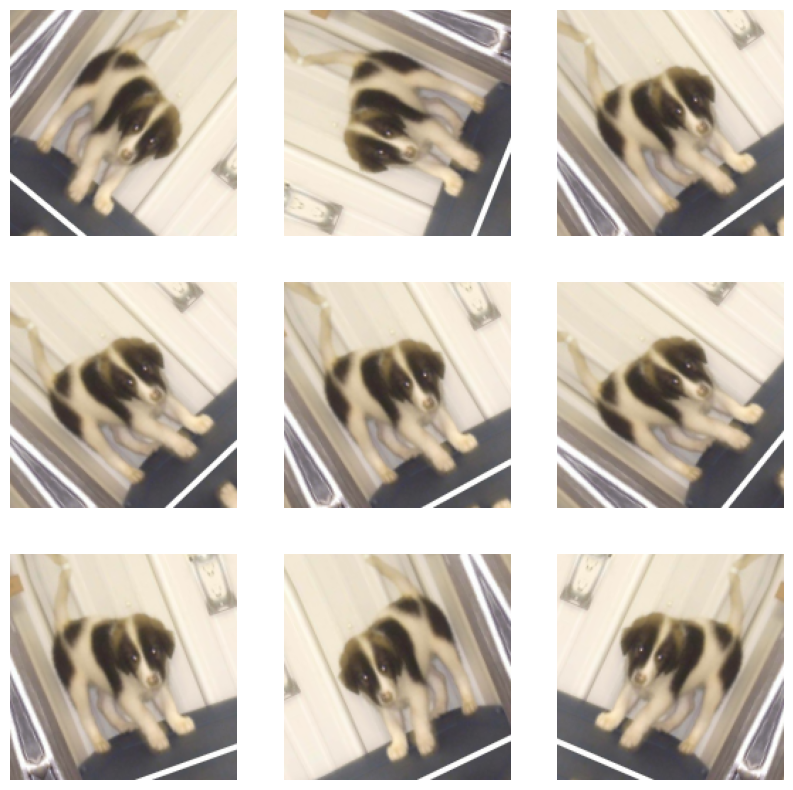

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### 重新缩放像素值

稍后，您将下载 `tf.keras.applications.MobileNetV2` 作为基础模型。此模型期望像素值处于 `[-1, 1]` 范围内，但此时，图像中的像素值处于 `[0, 255]` 范围内。要重新缩放这些像素值，请使用模型随附的预处理方法。

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

注：另外，您也可以使用 `tf.keras.layers.Rescaling` 将像素值从 `[0, 255]` 重新缩放为 `[-1, 1]`。

In [13]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

注：如果使用其他 `tf.keras.applications`，请确保查阅 API 文档以确定它们是否期望 `[-1,1]` 或 `[0, 1]` 范围内的像素，或者使用随附的 `preprocess_input` 函数。

## 从预训练卷积网络创建基础模型

您将根据 Google 开发的 **MobileNet V2** 模型来创建基础模型。此模型已基于 ImageNet 数据集进行预训练，ImageNet 数据集是一个包含 140 万个图像和 1000 个类的大型数据集。ImageNet 是一个研究训练数据集，具有各种各样的类别，例如 `jackfruit` 和 `syringe`。此知识库将帮助我们对特定数据集中的猫和狗进行分类。

首先，您需要选择将 MobileNet V2 的哪一层用于特征提取。最后的分类层（在“顶部”，因为大多数机器学习模型的图表是从下到上的）不是很有用。相反，您将按照常见做法依赖于展平操作之前的最后一层。此层被称为“瓶颈层”。与最后一层/顶层相比，瓶颈层的特征保留了更多的通用性。

首先，实例化一个已预加载基于 ImageNet 训练的权重的 MobileNet V2 模型。通过指定 **include_top=False** 参数，可以加载不包括顶部分类层的网络，这对于特征提取十分理想。

In [14]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


9406464/9406464 [==============================] - 1s 0us/step


此特征提取程序将每个 `160x160x3` 图像转换为 `5x5x1280` 的特征块。我们看看它对一批示例图像做了些什么：

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## 特征提取

在此步骤中，您将冻结在上一步中创建的卷积基，并用作特征提取程序。此外，您还可以在其顶部添加分类器以及训练顶级分类器。

### 冻结卷积基

在编译和训练模型之前，冻结卷积基至关重要。冻结（通过设置 layer.trainable = False）可避免在训练期间更新给定层中的权重。MobileNet V2 具有许多层，因此将整个模型的 `trainable` 标记设置为 False 会冻结所有这些层。

In [16]:
base_model.trainable = False

### 有关 BatchNormalization 层的重要说明

许多模型都包含 `tf.keras.layers.BatchNormalization` 层。此层是一个特例，应在微调的上下文中采取预防措施，如本教程后面所示。

设置 `layer.trainable = False` 时，`BatchNormalization` 层将以推断模式运行，并且不会更新其均值和方差统计信息。

解冻包含 BatchNormalization 层的模型以进行微调时，应在调用基础模型时通过传递 `training = False` 来使 BatchNormalization 层保持在推断模式下。否则，应用于不可训练权重的更新将破坏模型已经学习到的内容。

有关详情，请参阅[迁移学习指南](https://tensorflow.google.cn/guide/keras/transfer_learning)。

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

### 添加分类头

要从特征块生成预测，请使用 `tf.keras.layers.GlobalAveragePooling2D` 层在 `5x5` 空间位置内取平均值，以将特征转换成每个图像一个向量（包含 1280 个元素）。

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


应用 `tf.keras.layers.Dense` 层将这些特征转换成每个图像一个预测。您在此处不需要激活函数，因为此预测将被视为 `logit` 或原始预测值。正数预测 1 类，负数预测 0 类。

In [19]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


通过使用 [Keras 函数式 API](https://tensorflow.google.cn/guide/keras/functional) 将数据扩充、重新缩放、base_model 和特征提取程序层链接在一起来构建模型。如前面所述，由于我们的模型包含 BatchNormalization 层，因此请使用 training = False。

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### 编译模型

在训练模型前，需要先编译模型。由于存在两个类，并且模型提供线性输出，请将 `tf.keras.losses.BinaryCrossentropy` 损失与 `from_logits=True` 结合使用。

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         


 sequential (Sequential)     (None, 160, 160, 3)       0         


 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         


 a)                                                              


 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         


 da)                                                             


 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   


 tional)                                                         


 global_average_pooling2d (  (None, 1280)              0         


 GlobalAveragePooling2D)                                         


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 1)                 1281      


Total params: 2259265 (8.62 MB)


Trainable params: 1281 (5.00 KB)


Non-trainable params: 2257984 (8.61 MB)


_________________________________________________________________


MobileNet 中的 250 万个参数被冻结，但在密集层中有 1200 个*可训练*参数。它们分为两个 `tf.Variable` 对象，即权重和偏差。

In [23]:
len(model.trainable_variables)

2

### 训练模型

经过 10 个周期的训练后，您应该在验证集上看到约 94% 的准确率。


In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)


 1/26 [>.............................] - ETA: 1:11 - loss: 0.7027 - accuracy: 0.6562


 4/26 [===>..........................] - ETA: 0s - loss: 0.6989 - accuracy: 0.6016  


 7/26 [=======>......................] - ETA: 0s - loss: 0.7036 - accuracy: 0.5670


10/26 [==========>...................] - ETA: 0s - loss: 0.7223 - accuracy: 0.5312


13/26 [==============>...............] - ETA: 0s - loss: 0.7074 - accuracy: 0.5312


16/26 [=================>............] - ETA: 0s - loss: 0.7140 - accuracy: 0.5195


19/26 [====================>.........] - ETA: 0s - loss: 0.7178 - accuracy: 0.5181


22/26 [========================>.....] - ETA: 0s - loss: 0.7224 - accuracy: 0.5256


25/26 [===========================>..] - ETA: 0s - loss: 0.7221 - accuracy: 0.5288


26/26 [==============================] - ETA: 0s - loss: 0.7217 - accuracy: 0.5248


26/26 [==============================] - 4s 53ms/step - loss: 0.7217 - accuracy: 0.5248


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.72
initial accuracy: 0.52


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10



 1/63 [..............................] - ETA: 4:21 - loss: 0.6141 - accuracy: 0.5000


 3/63 [>.............................] - ETA: 2s - loss: 0.7108 - accuracy: 0.5104  

I0000 00:00:1699397221.424354  479646 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



 5/63 [=>............................] - ETA: 1s - loss: 0.7330 - accuracy: 0.5250


 7/63 [==>...........................] - ETA: 1s - loss: 0.7043 - accuracy: 0.5670


 9/63 [===>..........................] - ETA: 1s - loss: 0.7082 - accuracy: 0.5625


11/63 [====>.........................] - ETA: 1s - loss: 0.7082 - accuracy: 0.5710


13/63 [=====>........................] - ETA: 1s - loss: 0.7056 - accuracy: 0.5793


15/63 [======>.......................] - ETA: 1s - loss: 0.6983 - accuracy: 0.5917


17/63 [=======>......................] - ETA: 1s - loss: 0.6980 - accuracy: 0.5790


19/63 [========>.....................] - ETA: 1s - loss: 0.6982 - accuracy: 0.5757


21/63 [=========>....................] - ETA: 1s - loss: 0.6863 - accuracy: 0.5804


23/63 [=========>....................] - ETA: 1s - loss: 0.6842 - accuracy: 0.5829


25/63 [==========>...................] - ETA: 1s - loss: 0.6853 - accuracy: 0.5813


27/63 [===========>..................] - ETA: 1s - loss: 0.6881 - accuracy: 0.5775


29/63 [============>.................] - ETA: 0s - loss: 0.6963 - accuracy: 0.5711


31/63 [=============>................] - ETA: 0s - loss: 0.6885 - accuracy: 0.5756


33/63 [==============>...............] - ETA: 0s - loss: 0.6875 - accuracy: 0.5710


35/63 [===============>..............] - ETA: 0s - loss: 0.6843 - accuracy: 0.5750


37/63 [================>.............] - ETA: 0s - loss: 0.6798 - accuracy: 0.5785


39/63 [=================>............] - ETA: 0s - loss: 0.6752 - accuracy: 0.5809


41/63 [==================>...........] - ETA: 0s - loss: 0.6747 - accuracy: 0.5838


43/63 [===================>..........] - ETA: 0s - loss: 0.6703 - accuracy: 0.5887


45/63 [====================>.........] - ETA: 0s - loss: 0.6691 - accuracy: 0.5917


47/63 [=====================>........] - ETA: 0s - loss: 0.6669 - accuracy: 0.5931


49/63 [======================>.......] - ETA: 0s - loss: 0.6646 - accuracy: 0.5982


51/63 [=======================>......] - ETA: 0s - loss: 0.6610 - accuracy: 0.5987


53/63 [========================>.....] - ETA: 0s - loss: 0.6633 - accuracy: 0.5973


55/63 [=========================>....] - ETA: 0s - loss: 0.6612 - accuracy: 0.6028


57/63 [==========================>...] - ETA: 0s - loss: 0.6551 - accuracy: 0.6086


59/63 [===========================>..] - ETA: 0s - loss: 0.6485 - accuracy: 0.6160


62/63 [============================>.] - ETA: 0s - loss: 0.6393 - accuracy: 0.6230


63/63 [==============================] - ETA: 0s - loss: 0.6391 - accuracy: 0.6240


63/63 [==============================] - 7s 51ms/step - loss: 0.6391 - accuracy: 0.6240 - val_loss: 0.4973 - val_accuracy: 0.7116


Epoch 2/10



 1/63 [..............................] - ETA: 3s - loss: 0.6483 - accuracy: 0.5938


 3/63 [>.............................] - ETA: 1s - loss: 0.5070 - accuracy: 0.7396


 5/63 [=>............................] - ETA: 1s - loss: 0.5297 - accuracy: 0.7063


 7/63 [==>...........................] - ETA: 1s - loss: 0.5495 - accuracy: 0.6562


 9/63 [===>..........................] - ETA: 1s - loss: 0.5557 - accuracy: 0.6493


11/63 [====>.........................] - ETA: 1s - loss: 0.5435 - accuracy: 0.6705


13/63 [=====>........................] - ETA: 1s - loss: 0.5236 - accuracy: 0.6851


15/63 [======>.......................] - ETA: 1s - loss: 0.5162 - accuracy: 0.6938


17/63 [=======>......................] - ETA: 1s - loss: 0.5083 - accuracy: 0.6949


19/63 [========>.....................] - ETA: 1s - loss: 0.5047 - accuracy: 0.6924


21/63 [=========>....................] - ETA: 1s - loss: 0.5012 - accuracy: 0.6979


23/63 [=========>....................] - ETA: 1s - loss: 0.4923 - accuracy: 0.7024


25/63 [==========>...................] - ETA: 0s - loss: 0.4935 - accuracy: 0.7038


27/63 [===========>..................] - ETA: 0s - loss: 0.4945 - accuracy: 0.7049


29/63 [============>.................] - ETA: 0s - loss: 0.4931 - accuracy: 0.7080


31/63 [=============>................] - ETA: 0s - loss: 0.4926 - accuracy: 0.7077


33/63 [==============>...............] - ETA: 0s - loss: 0.4931 - accuracy: 0.7112


35/63 [===============>..............] - ETA: 0s - loss: 0.4948 - accuracy: 0.7107


37/63 [================>.............] - ETA: 0s - loss: 0.4911 - accuracy: 0.7162


39/63 [=================>............] - ETA: 0s - loss: 0.4891 - accuracy: 0.7171


41/63 [==================>...........] - ETA: 0s - loss: 0.4917 - accuracy: 0.7195


43/63 [===================>..........] - ETA: 0s - loss: 0.4895 - accuracy: 0.7217


45/63 [====================>.........] - ETA: 0s - loss: 0.4849 - accuracy: 0.7312


47/63 [=====================>........] - ETA: 0s - loss: 0.4797 - accuracy: 0.7387


49/63 [======================>.......] - ETA: 0s - loss: 0.4749 - accuracy: 0.7423


51/63 [=======================>......] - ETA: 0s - loss: 0.4751 - accuracy: 0.7433


53/63 [========================>.....] - ETA: 0s - loss: 0.4752 - accuracy: 0.7447


55/63 [=========================>....] - ETA: 0s - loss: 0.4748 - accuracy: 0.7455


57/63 [==========================>...] - ETA: 0s - loss: 0.4731 - accuracy: 0.7473


59/63 [===========================>..] - ETA: 0s - loss: 0.4737 - accuracy: 0.7479


61/63 [============================>.] - ETA: 0s - loss: 0.4721 - accuracy: 0.7500


63/63 [==============================] - 2s 36ms/step - loss: 0.4712 - accuracy: 0.7495 - val_loss: 0.3682 - val_accuracy: 0.8502


Epoch 3/10



 1/63 [..............................] - ETA: 3s - loss: 0.3793 - accuracy: 0.8438


 3/63 [>.............................] - ETA: 1s - loss: 0.4193 - accuracy: 0.8125


 5/63 [=>............................] - ETA: 1s - loss: 0.4225 - accuracy: 0.7875


 7/63 [==>...........................] - ETA: 1s - loss: 0.4211 - accuracy: 0.7902


 9/63 [===>..........................] - ETA: 1s - loss: 0.4176 - accuracy: 0.7847


11/63 [====>.........................] - ETA: 1s - loss: 0.4123 - accuracy: 0.7955


13/63 [=====>........................] - ETA: 1s - loss: 0.4018 - accuracy: 0.7957


15/63 [======>.......................] - ETA: 1s - loss: 0.3951 - accuracy: 0.8062


17/63 [=======>......................] - ETA: 1s - loss: 0.3925 - accuracy: 0.8125


19/63 [========>.....................] - ETA: 1s - loss: 0.3863 - accuracy: 0.8174


21/63 [=========>....................] - ETA: 1s - loss: 0.3826 - accuracy: 0.8170


23/63 [=========>....................] - ETA: 1s - loss: 0.3900 - accuracy: 0.8139


25/63 [==========>...................] - ETA: 0s - loss: 0.3903 - accuracy: 0.8112


27/63 [===========>..................] - ETA: 0s - loss: 0.3925 - accuracy: 0.8032


29/63 [============>.................] - ETA: 0s - loss: 0.3890 - accuracy: 0.8039


31/63 [=============>................] - ETA: 0s - loss: 0.3920 - accuracy: 0.8024


33/63 [==============>...............] - ETA: 0s - loss: 0.3900 - accuracy: 0.8049


35/63 [===============>..............] - ETA: 0s - loss: 0.3895 - accuracy: 0.8054


37/63 [================>.............] - ETA: 0s - loss: 0.3890 - accuracy: 0.8049


39/63 [=================>............] - ETA: 0s - loss: 0.3879 - accuracy: 0.8085


41/63 [==================>...........] - ETA: 0s - loss: 0.3843 - accuracy: 0.8125


43/63 [===================>..........] - ETA: 0s - loss: 0.3826 - accuracy: 0.8140


45/63 [====================>.........] - ETA: 0s - loss: 0.3790 - accuracy: 0.8160


47/63 [=====================>........] - ETA: 0s - loss: 0.3776 - accuracy: 0.8178


49/63 [======================>.......] - ETA: 0s - loss: 0.3768 - accuracy: 0.8195


51/63 [=======================>......] - ETA: 0s - loss: 0.3778 - accuracy: 0.8192


53/63 [========================>.....] - ETA: 0s - loss: 0.3805 - accuracy: 0.8166


55/63 [=========================>....] - ETA: 0s - loss: 0.3813 - accuracy: 0.8170


57/63 [==========================>...] - ETA: 0s - loss: 0.3810 - accuracy: 0.8158


59/63 [===========================>..] - ETA: 0s - loss: 0.3793 - accuracy: 0.8189


61/63 [============================>.] - ETA: 0s - loss: 0.3812 - accuracy: 0.8186


63/63 [==============================] - 2s 36ms/step - loss: 0.3823 - accuracy: 0.8185 - val_loss: 0.2906 - val_accuracy: 0.8837


Epoch 4/10



 1/63 [..............................] - ETA: 3s - loss: 0.4784 - accuracy: 0.8125


 3/63 [>.............................] - ETA: 1s - loss: 0.3870 - accuracy: 0.8542


 5/63 [=>............................] - ETA: 1s - loss: 0.3777 - accuracy: 0.8062


 7/63 [==>...........................] - ETA: 1s - loss: 0.3619 - accuracy: 0.8125


 9/63 [===>..........................] - ETA: 1s - loss: 0.3608 - accuracy: 0.8056


11/63 [====>.........................] - ETA: 1s - loss: 0.3521 - accuracy: 0.8125


13/63 [=====>........................] - ETA: 1s - loss: 0.3479 - accuracy: 0.8197


15/63 [======>.......................] - ETA: 1s - loss: 0.3410 - accuracy: 0.8292


17/63 [=======>......................] - ETA: 1s - loss: 0.3332 - accuracy: 0.8346


19/63 [========>.....................] - ETA: 1s - loss: 0.3393 - accuracy: 0.8306


21/63 [=========>....................] - ETA: 1s - loss: 0.3393 - accuracy: 0.8363


23/63 [=========>....................] - ETA: 1s - loss: 0.3406 - accuracy: 0.8370


25/63 [==========>...................] - ETA: 0s - loss: 0.3360 - accuracy: 0.8388


27/63 [===========>..................] - ETA: 0s - loss: 0.3372 - accuracy: 0.8345


29/63 [============>.................] - ETA: 0s - loss: 0.3325 - accuracy: 0.8373


31/63 [=============>................] - ETA: 0s - loss: 0.3303 - accuracy: 0.8387


33/63 [==============>...............] - ETA: 0s - loss: 0.3269 - accuracy: 0.8428


35/63 [===============>..............] - ETA: 0s - loss: 0.3289 - accuracy: 0.8411


37/63 [================>.............] - ETA: 0s - loss: 0.3257 - accuracy: 0.8429


39/63 [=================>............] - ETA: 0s - loss: 0.3222 - accuracy: 0.8470


41/63 [==================>...........] - ETA: 0s - loss: 0.3272 - accuracy: 0.8430


43/63 [===================>..........] - ETA: 0s - loss: 0.3287 - accuracy: 0.8438


45/63 [====================>.........] - ETA: 0s - loss: 0.3283 - accuracy: 0.8451


47/63 [=====================>........] - ETA: 0s - loss: 0.3269 - accuracy: 0.8471


49/63 [======================>.......] - ETA: 0s - loss: 0.3282 - accuracy: 0.8476


51/63 [=======================>......] - ETA: 0s - loss: 0.3281 - accuracy: 0.8468


53/63 [========================>.....] - ETA: 0s - loss: 0.3329 - accuracy: 0.8467


55/63 [=========================>....] - ETA: 0s - loss: 0.3312 - accuracy: 0.8483


57/63 [==========================>...] - ETA: 0s - loss: 0.3320 - accuracy: 0.8487


59/63 [===========================>..] - ETA: 0s - loss: 0.3295 - accuracy: 0.8512


61/63 [============================>.] - ETA: 0s - loss: 0.3289 - accuracy: 0.8514


63/63 [==============================] - 2s 36ms/step - loss: 0.3285 - accuracy: 0.8515 - val_loss: 0.2367 - val_accuracy: 0.9109


Epoch 5/10



 1/63 [..............................] - ETA: 3s - loss: 0.2552 - accuracy: 0.9062


 3/63 [>.............................] - ETA: 1s - loss: 0.2800 - accuracy: 0.9167


 5/63 [=>............................] - ETA: 1s - loss: 0.3031 - accuracy: 0.8938


 7/63 [==>...........................] - ETA: 1s - loss: 0.3016 - accuracy: 0.8839


 9/63 [===>..........................] - ETA: 1s - loss: 0.2997 - accuracy: 0.8750


11/63 [====>.........................] - ETA: 1s - loss: 0.3042 - accuracy: 0.8722


13/63 [=====>........................] - ETA: 1s - loss: 0.3123 - accuracy: 0.8678


15/63 [======>.......................] - ETA: 1s - loss: 0.3206 - accuracy: 0.8646


17/63 [=======>......................] - ETA: 1s - loss: 0.3134 - accuracy: 0.8676


19/63 [========>.....................] - ETA: 1s - loss: 0.3203 - accuracy: 0.8569


21/63 [=========>....................] - ETA: 1s - loss: 0.3226 - accuracy: 0.8557


23/63 [=========>....................] - ETA: 1s - loss: 0.3158 - accuracy: 0.8573


25/63 [==========>...................] - ETA: 0s - loss: 0.3129 - accuracy: 0.8612


27/63 [===========>..................] - ETA: 0s - loss: 0.3087 - accuracy: 0.8634


29/63 [============>.................] - ETA: 0s - loss: 0.3088 - accuracy: 0.8631


31/63 [=============>................] - ETA: 0s - loss: 0.3089 - accuracy: 0.8629


33/63 [==============>...............] - ETA: 0s - loss: 0.3047 - accuracy: 0.8665


35/63 [===============>..............] - ETA: 0s - loss: 0.3055 - accuracy: 0.8652


37/63 [================>.............] - ETA: 0s - loss: 0.3010 - accuracy: 0.8691


39/63 [=================>............] - ETA: 0s - loss: 0.2976 - accuracy: 0.8726


41/63 [==================>...........] - ETA: 0s - loss: 0.2948 - accuracy: 0.8742


43/63 [===================>..........] - ETA: 0s - loss: 0.2958 - accuracy: 0.8728


45/63 [====================>.........] - ETA: 0s - loss: 0.2956 - accuracy: 0.8736


47/63 [=====================>........] - ETA: 0s - loss: 0.2935 - accuracy: 0.8750


49/63 [======================>.......] - ETA: 0s - loss: 0.2943 - accuracy: 0.8763


51/63 [=======================>......] - ETA: 0s - loss: 0.2932 - accuracy: 0.8762


53/63 [========================>.....] - ETA: 0s - loss: 0.2912 - accuracy: 0.8779


55/63 [=========================>....] - ETA: 0s - loss: 0.2907 - accuracy: 0.8778


57/63 [==========================>...] - ETA: 0s - loss: 0.2882 - accuracy: 0.8805


59/63 [===========================>..] - ETA: 0s - loss: 0.2888 - accuracy: 0.8803


61/63 [============================>.] - ETA: 0s - loss: 0.2881 - accuracy: 0.8806


63/63 [==============================] - 2s 36ms/step - loss: 0.2870 - accuracy: 0.8820 - val_loss: 0.2036 - val_accuracy: 0.9245


Epoch 6/10



 1/63 [..............................] - ETA: 3s - loss: 0.2718 - accuracy: 0.8438


 3/63 [>.............................] - ETA: 1s - loss: 0.2636 - accuracy: 0.8542


 5/63 [=>............................] - ETA: 1s - loss: 0.2558 - accuracy: 0.8750


 7/63 [==>...........................] - ETA: 1s - loss: 0.2532 - accuracy: 0.8839


 9/63 [===>..........................] - ETA: 1s - loss: 0.2580 - accuracy: 0.8785


11/63 [====>.........................] - ETA: 1s - loss: 0.2692 - accuracy: 0.8778


13/63 [=====>........................] - ETA: 1s - loss: 0.2771 - accuracy: 0.8726


15/63 [======>.......................] - ETA: 1s - loss: 0.2789 - accuracy: 0.8729


17/63 [=======>......................] - ETA: 1s - loss: 0.2894 - accuracy: 0.8658


19/63 [========>.....................] - ETA: 1s - loss: 0.2915 - accuracy: 0.8651


21/63 [=========>....................] - ETA: 1s - loss: 0.2856 - accuracy: 0.8661


23/63 [=========>....................] - ETA: 1s - loss: 0.2908 - accuracy: 0.8655


25/63 [==========>...................] - ETA: 0s - loss: 0.2846 - accuracy: 0.8700


27/63 [===========>..................] - ETA: 0s - loss: 0.2797 - accuracy: 0.8738


29/63 [============>.................] - ETA: 0s - loss: 0.2742 - accuracy: 0.8782


31/63 [=============>................] - ETA: 0s - loss: 0.2735 - accuracy: 0.8790


33/63 [==============>...............] - ETA: 0s - loss: 0.2687 - accuracy: 0.8816


35/63 [===============>..............] - ETA: 0s - loss: 0.2700 - accuracy: 0.8821


37/63 [================>.............] - ETA: 0s - loss: 0.2667 - accuracy: 0.8851


39/63 [=================>............] - ETA: 0s - loss: 0.2635 - accuracy: 0.8862


41/63 [==================>...........] - ETA: 0s - loss: 0.2602 - accuracy: 0.8880


43/63 [===================>..........] - ETA: 0s - loss: 0.2577 - accuracy: 0.8903


45/63 [====================>.........] - ETA: 0s - loss: 0.2592 - accuracy: 0.8903


47/63 [=====================>........] - ETA: 0s - loss: 0.2569 - accuracy: 0.8916


49/63 [======================>.......] - ETA: 0s - loss: 0.2561 - accuracy: 0.8929


51/63 [=======================>......] - ETA: 0s - loss: 0.2600 - accuracy: 0.8903


53/63 [========================>.....] - ETA: 0s - loss: 0.2620 - accuracy: 0.8892


55/63 [=========================>....] - ETA: 0s - loss: 0.2646 - accuracy: 0.8875


57/63 [==========================>...] - ETA: 0s - loss: 0.2658 - accuracy: 0.8854


59/63 [===========================>..] - ETA: 0s - loss: 0.2650 - accuracy: 0.8856


61/63 [============================>.] - ETA: 0s - loss: 0.2631 - accuracy: 0.8878


63/63 [==============================] - 2s 36ms/step - loss: 0.2635 - accuracy: 0.8885 - val_loss: 0.1812 - val_accuracy: 0.9394


Epoch 7/10



 1/63 [..............................] - ETA: 3s - loss: 0.2984 - accuracy: 0.8750


 3/63 [>.............................] - ETA: 1s - loss: 0.2474 - accuracy: 0.8750


 5/63 [=>............................] - ETA: 1s - loss: 0.2531 - accuracy: 0.8813


 7/63 [==>...........................] - ETA: 1s - loss: 0.2352 - accuracy: 0.8929


 9/63 [===>..........................] - ETA: 1s - loss: 0.2323 - accuracy: 0.8924


11/63 [====>.........................] - ETA: 1s - loss: 0.2428 - accuracy: 0.8977


13/63 [=====>........................] - ETA: 1s - loss: 0.2540 - accuracy: 0.8918


15/63 [======>.......................] - ETA: 1s - loss: 0.2482 - accuracy: 0.8979


17/63 [=======>......................] - ETA: 1s - loss: 0.2571 - accuracy: 0.8952


19/63 [========>.....................] - ETA: 1s - loss: 0.2602 - accuracy: 0.8914


21/63 [=========>....................] - ETA: 1s - loss: 0.2628 - accuracy: 0.8869


23/63 [=========>....................] - ETA: 1s - loss: 0.2672 - accuracy: 0.8804


25/63 [==========>...................] - ETA: 0s - loss: 0.2672 - accuracy: 0.8838


27/63 [===========>..................] - ETA: 0s - loss: 0.2619 - accuracy: 0.8877


29/63 [============>.................] - ETA: 0s - loss: 0.2617 - accuracy: 0.8879


31/63 [=============>................] - ETA: 0s - loss: 0.2566 - accuracy: 0.8901


33/63 [==============>...............] - ETA: 0s - loss: 0.2548 - accuracy: 0.8920


35/63 [===============>..............] - ETA: 0s - loss: 0.2544 - accuracy: 0.8929


37/63 [================>.............] - ETA: 0s - loss: 0.2516 - accuracy: 0.8919


39/63 [=================>............] - ETA: 0s - loss: 0.2476 - accuracy: 0.8950


41/63 [==================>...........] - ETA: 0s - loss: 0.2493 - accuracy: 0.8941


43/63 [===================>..........] - ETA: 0s - loss: 0.2443 - accuracy: 0.8968


45/63 [====================>.........] - ETA: 0s - loss: 0.2419 - accuracy: 0.8979


47/63 [=====================>........] - ETA: 0s - loss: 0.2424 - accuracy: 0.8963


49/63 [======================>.......] - ETA: 0s - loss: 0.2385 - accuracy: 0.8986


51/63 [=======================>......] - ETA: 0s - loss: 0.2376 - accuracy: 0.8995


53/63 [========================>.....] - ETA: 0s - loss: 0.2404 - accuracy: 0.8998


55/63 [=========================>....] - ETA: 0s - loss: 0.2423 - accuracy: 0.8989


57/63 [==========================>...] - ETA: 0s - loss: 0.2437 - accuracy: 0.8980


59/63 [===========================>..] - ETA: 0s - loss: 0.2445 - accuracy: 0.8962


61/63 [============================>.] - ETA: 0s - loss: 0.2453 - accuracy: 0.8955


63/63 [==============================] - 2s 36ms/step - loss: 0.2469 - accuracy: 0.8950 - val_loss: 0.1648 - val_accuracy: 0.9406


Epoch 8/10



 1/63 [..............................] - ETA: 3s - loss: 0.2407 - accuracy: 0.8438


 3/63 [>.............................] - ETA: 1s - loss: 0.2556 - accuracy: 0.8750


 5/63 [=>............................] - ETA: 1s - loss: 0.2583 - accuracy: 0.8625


 7/63 [==>...........................] - ETA: 1s - loss: 0.2479 - accuracy: 0.8750


 9/63 [===>..........................] - ETA: 1s - loss: 0.2366 - accuracy: 0.8924


11/63 [====>.........................] - ETA: 1s - loss: 0.2315 - accuracy: 0.9006


13/63 [=====>........................] - ETA: 1s - loss: 0.2329 - accuracy: 0.9038


15/63 [======>.......................] - ETA: 1s - loss: 0.2237 - accuracy: 0.9104


17/63 [=======>......................] - ETA: 1s - loss: 0.2252 - accuracy: 0.9118


19/63 [========>.....................] - ETA: 1s - loss: 0.2240 - accuracy: 0.9112


21/63 [=========>....................] - ETA: 1s - loss: 0.2224 - accuracy: 0.9152


23/63 [=========>....................] - ETA: 1s - loss: 0.2226 - accuracy: 0.9117


25/63 [==========>...................] - ETA: 0s - loss: 0.2271 - accuracy: 0.9050


27/63 [===========>..................] - ETA: 0s - loss: 0.2267 - accuracy: 0.9062


29/63 [============>.................] - ETA: 0s - loss: 0.2274 - accuracy: 0.9041


31/63 [=============>................] - ETA: 0s - loss: 0.2249 - accuracy: 0.9052


33/63 [==============>...............] - ETA: 0s - loss: 0.2237 - accuracy: 0.9053


35/63 [===============>..............] - ETA: 0s - loss: 0.2321 - accuracy: 0.9027


37/63 [================>.............] - ETA: 0s - loss: 0.2282 - accuracy: 0.9054


39/63 [=================>............] - ETA: 0s - loss: 0.2257 - accuracy: 0.9079


41/63 [==================>...........] - ETA: 0s - loss: 0.2257 - accuracy: 0.9085


43/63 [===================>..........] - ETA: 0s - loss: 0.2251 - accuracy: 0.9092


45/63 [====================>.........] - ETA: 0s - loss: 0.2226 - accuracy: 0.9118


47/63 [=====================>........] - ETA: 0s - loss: 0.2218 - accuracy: 0.9109


49/63 [======================>.......] - ETA: 0s - loss: 0.2227 - accuracy: 0.9101


51/63 [=======================>......] - ETA: 0s - loss: 0.2216 - accuracy: 0.9112


53/63 [========================>.....] - ETA: 0s - loss: 0.2240 - accuracy: 0.9080


55/63 [=========================>....] - ETA: 0s - loss: 0.2247 - accuracy: 0.9080


57/63 [==========================>...] - ETA: 0s - loss: 0.2249 - accuracy: 0.9084


59/63 [===========================>..] - ETA: 0s - loss: 0.2259 - accuracy: 0.9062


62/63 [============================>.] - ETA: 0s - loss: 0.2273 - accuracy: 0.9057


63/63 [==============================] - 2s 36ms/step - loss: 0.2294 - accuracy: 0.9045 - val_loss: 0.1523 - val_accuracy: 0.9480


Epoch 9/10



 1/63 [..............................] - ETA: 3s - loss: 0.1839 - accuracy: 0.9375


 3/63 [>.............................] - ETA: 1s - loss: 0.1979 - accuracy: 0.9271


 5/63 [=>............................] - ETA: 1s - loss: 0.2017 - accuracy: 0.9250


 7/63 [==>...........................] - ETA: 1s - loss: 0.2115 - accuracy: 0.9107


 9/63 [===>..........................] - ETA: 1s - loss: 0.2190 - accuracy: 0.9028


11/63 [====>.........................] - ETA: 1s - loss: 0.2007 - accuracy: 0.9091


13/63 [=====>........................] - ETA: 1s - loss: 0.2194 - accuracy: 0.8942


15/63 [======>.......................] - ETA: 1s - loss: 0.2218 - accuracy: 0.8938


17/63 [=======>......................] - ETA: 1s - loss: 0.2198 - accuracy: 0.8952


19/63 [========>.....................] - ETA: 1s - loss: 0.2287 - accuracy: 0.8947


21/63 [=========>....................] - ETA: 1s - loss: 0.2248 - accuracy: 0.8943


23/63 [=========>....................] - ETA: 1s - loss: 0.2283 - accuracy: 0.8967


25/63 [==========>...................] - ETA: 0s - loss: 0.2319 - accuracy: 0.8975


27/63 [===========>..................] - ETA: 0s - loss: 0.2282 - accuracy: 0.8981


29/63 [============>.................] - ETA: 0s - loss: 0.2279 - accuracy: 0.8976


31/63 [=============>................] - ETA: 0s - loss: 0.2257 - accuracy: 0.9002


33/63 [==============>...............] - ETA: 0s - loss: 0.2249 - accuracy: 0.8977


35/63 [===============>..............] - ETA: 0s - loss: 0.2259 - accuracy: 0.8955


37/63 [================>.............] - ETA: 0s - loss: 0.2300 - accuracy: 0.8961


39/63 [=================>............] - ETA: 0s - loss: 0.2300 - accuracy: 0.8958


41/63 [==================>...........] - ETA: 0s - loss: 0.2274 - accuracy: 0.8979


43/63 [===================>..........] - ETA: 0s - loss: 0.2270 - accuracy: 0.8990


45/63 [====================>.........] - ETA: 0s - loss: 0.2242 - accuracy: 0.9000


47/63 [=====================>........] - ETA: 0s - loss: 0.2269 - accuracy: 0.8983


49/63 [======================>.......] - ETA: 0s - loss: 0.2277 - accuracy: 0.8980


51/63 [=======================>......] - ETA: 0s - loss: 0.2243 - accuracy: 0.9007


53/63 [========================>.....] - ETA: 0s - loss: 0.2273 - accuracy: 0.8986


55/63 [=========================>....] - ETA: 0s - loss: 0.2264 - accuracy: 0.8977


57/63 [==========================>...] - ETA: 0s - loss: 0.2277 - accuracy: 0.8975


59/63 [===========================>..] - ETA: 0s - loss: 0.2267 - accuracy: 0.8972


61/63 [============================>.] - ETA: 0s - loss: 0.2248 - accuracy: 0.8986


63/63 [==============================] - 2s 36ms/step - loss: 0.2258 - accuracy: 0.8990 - val_loss: 0.1371 - val_accuracy: 0.9530


Epoch 10/10



 1/63 [..............................] - ETA: 3s - loss: 0.1628 - accuracy: 0.9688


 3/63 [>.............................] - ETA: 1s - loss: 0.1819 - accuracy: 0.9271


 5/63 [=>............................] - ETA: 1s - loss: 0.1938 - accuracy: 0.9250


 7/63 [==>...........................] - ETA: 1s - loss: 0.2078 - accuracy: 0.9018


 9/63 [===>..........................] - ETA: 1s - loss: 0.2153 - accuracy: 0.8993


11/63 [====>.........................] - ETA: 1s - loss: 0.2127 - accuracy: 0.9006


13/63 [=====>........................] - ETA: 1s - loss: 0.2256 - accuracy: 0.8990


15/63 [======>.......................] - ETA: 1s - loss: 0.2247 - accuracy: 0.9021


17/63 [=======>......................] - ETA: 1s - loss: 0.2189 - accuracy: 0.9081


19/63 [========>.....................] - ETA: 1s - loss: 0.2188 - accuracy: 0.9095


21/63 [=========>....................] - ETA: 1s - loss: 0.2115 - accuracy: 0.9137


23/63 [=========>....................] - ETA: 1s - loss: 0.2103 - accuracy: 0.9130


25/63 [==========>...................] - ETA: 0s - loss: 0.2036 - accuracy: 0.9175


27/63 [===========>..................] - ETA: 0s - loss: 0.2083 - accuracy: 0.9167


29/63 [============>.................] - ETA: 0s - loss: 0.2118 - accuracy: 0.9159


31/63 [=============>................] - ETA: 0s - loss: 0.2105 - accuracy: 0.9163


33/63 [==============>...............] - ETA: 0s - loss: 0.2067 - accuracy: 0.9195


35/63 [===============>..............] - ETA: 0s - loss: 0.2067 - accuracy: 0.9179


37/63 [================>.............] - ETA: 0s - loss: 0.2091 - accuracy: 0.9147


39/63 [=================>............] - ETA: 0s - loss: 0.2063 - accuracy: 0.9167


41/63 [==================>...........] - ETA: 0s - loss: 0.2074 - accuracy: 0.9131


43/63 [===================>..........] - ETA: 0s - loss: 0.2025 - accuracy: 0.9164


45/63 [====================>.........] - ETA: 0s - loss: 0.2039 - accuracy: 0.9139


47/63 [=====================>........] - ETA: 0s - loss: 0.2026 - accuracy: 0.9142


49/63 [======================>.......] - ETA: 0s - loss: 0.2086 - accuracy: 0.9094


51/63 [=======================>......] - ETA: 0s - loss: 0.2104 - accuracy: 0.9093


53/63 [========================>.....] - ETA: 0s - loss: 0.2090 - accuracy: 0.9116


55/63 [=========================>....] - ETA: 0s - loss: 0.2103 - accuracy: 0.9119


57/63 [==========================>...] - ETA: 0s - loss: 0.2101 - accuracy: 0.9123


59/63 [===========================>..] - ETA: 0s - loss: 0.2100 - accuracy: 0.9126


61/63 [============================>.] - ETA: 0s - loss: 0.2085 - accuracy: 0.9144


63/63 [==============================] - 2s 36ms/step - loss: 0.2079 - accuracy: 0.9160 - val_loss: 0.1293 - val_accuracy: 0.9530


### 学习曲线

我们看一下使用 MobileNet V2 基础模型作为固定特征提取程序时训练和验证准确率/损失的学习曲线。

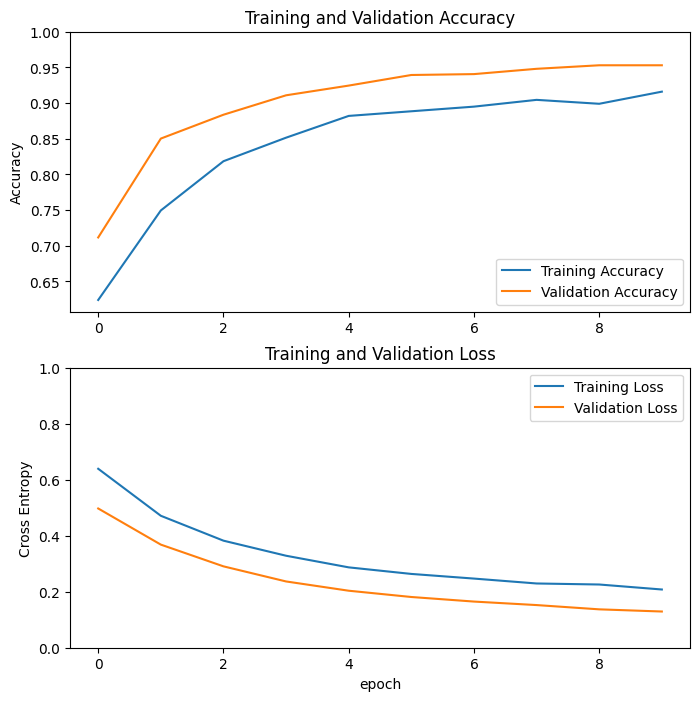

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

注：如果您想知道为什么验证指标明显优于训练指标，主要原因是 `tf.keras.layers.BatchNormalization` 和 `tf.keras.layers.Dropout` 等层会影响训练期间的准确率。在计算验证损失时，它们处于关闭状态。

在较小程度上，这也是因为训练指标报告的是某个周期的平均值，而验证指标则在经过该周期后才进行评估，因此验证指标会看到训练时间略长一些的模型。

## 微调

在特征提取实验中，您仅在 MobileNet V2 基础模型的顶部训练了一些层。预训练网络的权重在训练过程中**未**更新。

进一步提高性能的一种方式是在训练（或“微调”）预训练模型顶层的权重的同时，另外训练您添加的分类器。训练过程将强制权重从通用特征映射调整为专门与数据集相关联的特征。

注：只有在您使用设置为不可训练的预训练模型训练顶级分类器之后，才能尝试这样做。如果您在预训练模型的顶部添加一个随机初始化的分类器并尝试共同训练所有层，则梯度更新的幅度将过大（由于分类器的随机权重所致），这将导致您的预训练模型忘记它已经学习的内容。

另外，您还应尝试微调少量顶层而不是整个 MobileNet 模型。在大多数卷积网络中，层越高，它的专门程度就越高。前几层学习非常简单且通用的特征，这些特征可以泛化到几乎所有类型的图像。随着您向上层移动，这些特征越来越特定于训练模型所使用的数据集。微调的目标是使这些专用特征适应新的数据集，而不是覆盖通用学习。

### 解冻模型的顶层


您需要做的是解冻 `base_model` 并将底层设置为不可训练。随后，您应该重新编译模型（使这些更改生效的必需操作），然后恢复训练。

In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### 编译模型

当您正在训练一个大得多的模型并且想要重新调整预训练权重时，请务必在此阶段使用较低的学习率。否则，您的模型可能会很快过拟合。

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         


 sequential (Sequential)     (None, 160, 160, 3)       0         


 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         


 a)                                                              


 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         


 da)                                                             


 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   


 tional)                                                         


 global_average_pooling2d (  (None, 1280)              0         


 GlobalAveragePooling2D)                                         


 dropout (Dropout)           (None, 1280)              0         


 dense (Dense)               (None, 1)                 1281      


Total params: 2259265 (8.62 MB)


Trainable params: 1862721 (7.11 MB)


Non-trainable params: 396544 (1.51 MB)


_________________________________________________________________


In [32]:
len(model.trainable_variables)

56

### 继续训练模型

如果您已提前训练至收敛，则此步骤将使您的准确率提高几个百分点。

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20



 1/63 [..............................] - ETA: 8:51 - loss: 0.2459 - accuracy: 0.8750


 3/63 [>.............................] - ETA: 2s - loss: 0.1795 - accuracy: 0.9271  


 5/63 [=>............................] - ETA: 2s - loss: 0.2138 - accuracy: 0.8938


 7/63 [==>...........................] - ETA: 2s - loss: 0.1958 - accuracy: 0.9196


 9/63 [===>..........................] - ETA: 2s - loss: 0.1732 - accuracy: 0.9340


11/63 [====>.........................] - ETA: 2s - loss: 0.1693 - accuracy: 0.9347


13/63 [=====>........................] - ETA: 1s - loss: 0.1726 - accuracy: 0.9255


15/63 [======>.......................] - ETA: 1s - loss: 0.1669 - accuracy: 0.9333


17/63 [=======>......................] - ETA: 1s - loss: 0.1632 - accuracy: 0.9357


19/63 [========>.....................] - ETA: 1s - loss: 0.1639 - accuracy: 0.9359


21/63 [=========>....................] - ETA: 1s - loss: 0.1607 - accuracy: 0.9360


23/63 [=========>....................] - ETA: 1s - loss: 0.1647 - accuracy: 0.9348


25/63 [==========>...................] - ETA: 1s - loss: 0.1578 - accuracy: 0.9375


27/63 [===========>..................] - ETA: 1s - loss: 0.1679 - accuracy: 0.9340


29/63 [============>.................] - ETA: 1s - loss: 0.1715 - accuracy: 0.9332


31/63 [=============>................] - ETA: 1s - loss: 0.1724 - accuracy: 0.9325


33/63 [==============>...............] - ETA: 1s - loss: 0.1707 - accuracy: 0.9318


35/63 [===============>..............] - ETA: 1s - loss: 0.1714 - accuracy: 0.9312


37/63 [================>.............] - ETA: 0s - loss: 0.1749 - accuracy: 0.9299


39/63 [=================>............] - ETA: 0s - loss: 0.1692 - accuracy: 0.9335


41/63 [==================>...........] - ETA: 0s - loss: 0.1636 - accuracy: 0.9360


43/63 [===================>..........] - ETA: 0s - loss: 0.1607 - accuracy: 0.9375


45/63 [====================>.........] - ETA: 0s - loss: 0.1621 - accuracy: 0.9361


47/63 [=====================>........] - ETA: 0s - loss: 0.1604 - accuracy: 0.9362


49/63 [======================>.......] - ETA: 0s - loss: 0.1580 - accuracy: 0.9362


51/63 [=======================>......] - ETA: 0s - loss: 0.1550 - accuracy: 0.9381


53/63 [========================>.....] - ETA: 0s - loss: 0.1531 - accuracy: 0.9393


55/63 [=========================>....] - ETA: 0s - loss: 0.1562 - accuracy: 0.9381


57/63 [==========================>...] - ETA: 0s - loss: 0.1566 - accuracy: 0.9370


59/63 [===========================>..] - ETA: 0s - loss: 0.1550 - accuracy: 0.9370


61/63 [============================>.] - ETA: 0s - loss: 0.1532 - accuracy: 0.9375


63/63 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.9365


63/63 [==============================] - 13s 67ms/step - loss: 0.1550 - accuracy: 0.9365 - val_loss: 0.0698 - val_accuracy: 0.9678


Epoch 11/20



 1/63 [..............................] - ETA: 4s - loss: 0.0987 - accuracy: 0.9688


 3/63 [>.............................] - ETA: 2s - loss: 0.0811 - accuracy: 0.9792


 5/63 [=>............................] - ETA: 2s - loss: 0.1085 - accuracy: 0.9563


 7/63 [==>...........................] - ETA: 1s - loss: 0.0993 - accuracy: 0.9554


 9/63 [===>..........................] - ETA: 1s - loss: 0.1047 - accuracy: 0.9549


11/63 [====>.........................] - ETA: 1s - loss: 0.1139 - accuracy: 0.9545


13/63 [=====>........................] - ETA: 1s - loss: 0.1266 - accuracy: 0.9495


15/63 [======>.......................] - ETA: 1s - loss: 0.1297 - accuracy: 0.9479


17/63 [=======>......................] - ETA: 1s - loss: 0.1212 - accuracy: 0.9522


19/63 [========>.....................] - ETA: 1s - loss: 0.1137 - accuracy: 0.9572


21/63 [=========>....................] - ETA: 1s - loss: 0.1157 - accuracy: 0.9568


23/63 [=========>....................] - ETA: 1s - loss: 0.1206 - accuracy: 0.9565


25/63 [==========>...................] - ETA: 1s - loss: 0.1269 - accuracy: 0.9525


27/63 [===========>..................] - ETA: 1s - loss: 0.1261 - accuracy: 0.9525


29/63 [============>.................] - ETA: 1s - loss: 0.1310 - accuracy: 0.9494


31/63 [=============>................] - ETA: 1s - loss: 0.1281 - accuracy: 0.9506


33/63 [==============>...............] - ETA: 1s - loss: 0.1278 - accuracy: 0.9517


35/63 [===============>..............] - ETA: 0s - loss: 0.1251 - accuracy: 0.9527


37/63 [================>.............] - ETA: 0s - loss: 0.1226 - accuracy: 0.9535


39/63 [=================>............] - ETA: 0s - loss: 0.1191 - accuracy: 0.9551


41/63 [==================>...........] - ETA: 0s - loss: 0.1184 - accuracy: 0.9566


43/63 [===================>..........] - ETA: 0s - loss: 0.1213 - accuracy: 0.9564


45/63 [====================>.........] - ETA: 0s - loss: 0.1194 - accuracy: 0.9563


47/63 [=====================>........] - ETA: 0s - loss: 0.1168 - accuracy: 0.9568


49/63 [======================>.......] - ETA: 0s - loss: 0.1145 - accuracy: 0.9579


51/63 [=======================>......] - ETA: 0s - loss: 0.1125 - accuracy: 0.9589


53/63 [========================>.....] - ETA: 0s - loss: 0.1134 - accuracy: 0.9581


55/63 [=========================>....] - ETA: 0s - loss: 0.1160 - accuracy: 0.9580


57/63 [==========================>...] - ETA: 0s - loss: 0.1170 - accuracy: 0.9578


59/63 [===========================>..] - ETA: 0s - loss: 0.1209 - accuracy: 0.9566


61/63 [============================>.] - ETA: 0s - loss: 0.1199 - accuracy: 0.9565


63/63 [==============================] - ETA: 0s - loss: 0.1197 - accuracy: 0.9570


63/63 [==============================] - 3s 45ms/step - loss: 0.1197 - accuracy: 0.9570 - val_loss: 0.0575 - val_accuracy: 0.9752


Epoch 12/20



 1/63 [..............................] - ETA: 4s - loss: 0.0440 - accuracy: 1.0000


 3/63 [>.............................] - ETA: 2s - loss: 0.1419 - accuracy: 0.9479


 5/63 [=>............................] - ETA: 2s - loss: 0.1179 - accuracy: 0.9500


 7/63 [==>...........................] - ETA: 1s - loss: 0.0952 - accuracy: 0.9643


 9/63 [===>..........................] - ETA: 1s - loss: 0.0878 - accuracy: 0.9688


11/63 [====>.........................] - ETA: 1s - loss: 0.0791 - accuracy: 0.9688


13/63 [=====>........................] - ETA: 1s - loss: 0.0754 - accuracy: 0.9712


15/63 [======>.......................] - ETA: 1s - loss: 0.0776 - accuracy: 0.9688


17/63 [=======>......................] - ETA: 1s - loss: 0.0779 - accuracy: 0.9669


19/63 [========>.....................] - ETA: 1s - loss: 0.0873 - accuracy: 0.9655


21/63 [=========>....................] - ETA: 1s - loss: 0.0891 - accuracy: 0.9628


23/63 [=========>....................] - ETA: 1s - loss: 0.0842 - accuracy: 0.9660


25/63 [==========>...................] - ETA: 1s - loss: 0.0839 - accuracy: 0.9650


27/63 [===========>..................] - ETA: 1s - loss: 0.0851 - accuracy: 0.9653


29/63 [============>.................] - ETA: 1s - loss: 0.0844 - accuracy: 0.9655


31/63 [=============>................] - ETA: 1s - loss: 0.0883 - accuracy: 0.9647


33/63 [==============>...............] - ETA: 1s - loss: 0.0878 - accuracy: 0.9640


35/63 [===============>..............] - ETA: 0s - loss: 0.0907 - accuracy: 0.9625


37/63 [================>.............] - ETA: 0s - loss: 0.0907 - accuracy: 0.9620


39/63 [=================>............] - ETA: 0s - loss: 0.0940 - accuracy: 0.9615


41/63 [==================>...........] - ETA: 0s - loss: 0.0934 - accuracy: 0.9619


43/63 [===================>..........] - ETA: 0s - loss: 0.0939 - accuracy: 0.9622


45/63 [====================>.........] - ETA: 0s - loss: 0.0937 - accuracy: 0.9618


47/63 [=====================>........] - ETA: 0s - loss: 0.0985 - accuracy: 0.9608


49/63 [======================>.......] - ETA: 0s - loss: 0.1005 - accuracy: 0.9605


51/63 [=======================>......] - ETA: 0s - loss: 0.1017 - accuracy: 0.9589


53/63 [========================>.....] - ETA: 0s - loss: 0.1013 - accuracy: 0.9593


55/63 [=========================>....] - ETA: 0s - loss: 0.1030 - accuracy: 0.9591


57/63 [==========================>...] - ETA: 0s - loss: 0.1025 - accuracy: 0.9578


59/63 [===========================>..] - ETA: 0s - loss: 0.1024 - accuracy: 0.9576


61/63 [============================>.] - ETA: 0s - loss: 0.1010 - accuracy: 0.9580


63/63 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.9585


63/63 [==============================] - 3s 45ms/step - loss: 0.1005 - accuracy: 0.9585 - val_loss: 0.0525 - val_accuracy: 0.9752


Epoch 13/20



 1/63 [..............................] - ETA: 4s - loss: 0.0135 - accuracy: 1.0000


 3/63 [>.............................] - ETA: 2s - loss: 0.0729 - accuracy: 0.9792


 5/63 [=>............................] - ETA: 2s - loss: 0.0759 - accuracy: 0.9625


 7/63 [==>...........................] - ETA: 1s - loss: 0.0670 - accuracy: 0.9643


 9/63 [===>..........................] - ETA: 1s - loss: 0.0841 - accuracy: 0.9583


11/63 [====>.........................] - ETA: 1s - loss: 0.0907 - accuracy: 0.9602


13/63 [=====>........................] - ETA: 1s - loss: 0.0981 - accuracy: 0.9615


15/63 [======>.......................] - ETA: 1s - loss: 0.0995 - accuracy: 0.9583


17/63 [=======>......................] - ETA: 1s - loss: 0.0988 - accuracy: 0.9577


19/63 [========>.....................] - ETA: 1s - loss: 0.0950 - accuracy: 0.9605


21/63 [=========>....................] - ETA: 1s - loss: 0.0966 - accuracy: 0.9598


23/63 [=========>....................] - ETA: 1s - loss: 0.0972 - accuracy: 0.9592


25/63 [==========>...................] - ETA: 1s - loss: 0.1000 - accuracy: 0.9563


27/63 [===========>..................] - ETA: 1s - loss: 0.0964 - accuracy: 0.9583


29/63 [============>.................] - ETA: 1s - loss: 0.0944 - accuracy: 0.9591


31/63 [=============>................] - ETA: 1s - loss: 0.0961 - accuracy: 0.9597


33/63 [==============>...............] - ETA: 1s - loss: 0.0957 - accuracy: 0.9602


35/63 [===============>..............] - ETA: 0s - loss: 0.1050 - accuracy: 0.9563


37/63 [================>.............] - ETA: 0s - loss: 0.1011 - accuracy: 0.9586


39/63 [=================>............] - ETA: 0s - loss: 0.1001 - accuracy: 0.9591


41/63 [==================>...........] - ETA: 0s - loss: 0.0993 - accuracy: 0.9588


43/63 [===================>..........] - ETA: 0s - loss: 0.0982 - accuracy: 0.9586


45/63 [====================>.........] - ETA: 0s - loss: 0.1063 - accuracy: 0.9576


47/63 [=====================>........] - ETA: 0s - loss: 0.1029 - accuracy: 0.9588


49/63 [======================>.......] - ETA: 0s - loss: 0.1016 - accuracy: 0.9592


51/63 [=======================>......] - ETA: 0s - loss: 0.1022 - accuracy: 0.9589


53/63 [========================>.....] - ETA: 0s - loss: 0.1011 - accuracy: 0.9593


55/63 [=========================>....] - ETA: 0s - loss: 0.1017 - accuracy: 0.9585


57/63 [==========================>...] - ETA: 0s - loss: 0.1029 - accuracy: 0.9572


59/63 [===========================>..] - ETA: 0s - loss: 0.1030 - accuracy: 0.9576


61/63 [============================>.] - ETA: 0s - loss: 0.1014 - accuracy: 0.9585


63/63 [==============================] - ETA: 0s - loss: 0.1015 - accuracy: 0.9590


63/63 [==============================] - 3s 45ms/step - loss: 0.1015 - accuracy: 0.9590 - val_loss: 0.0477 - val_accuracy: 0.9790


Epoch 14/20



 1/63 [..............................] - ETA: 4s - loss: 0.0121 - accuracy: 1.0000


 3/63 [>.............................] - ETA: 2s - loss: 0.0546 - accuracy: 0.9792


 5/63 [=>............................] - ETA: 2s - loss: 0.0827 - accuracy: 0.9563


 7/63 [==>...........................] - ETA: 1s - loss: 0.1096 - accuracy: 0.9554


 9/63 [===>..........................] - ETA: 1s - loss: 0.0966 - accuracy: 0.9583


11/63 [====>.........................] - ETA: 1s - loss: 0.0937 - accuracy: 0.9631


13/63 [=====>........................] - ETA: 1s - loss: 0.0898 - accuracy: 0.9639


15/63 [======>.......................] - ETA: 1s - loss: 0.1056 - accuracy: 0.9583


17/63 [=======>......................] - ETA: 1s - loss: 0.1132 - accuracy: 0.9559


19/63 [========>.....................] - ETA: 1s - loss: 0.1088 - accuracy: 0.9589


21/63 [=========>....................] - ETA: 1s - loss: 0.1080 - accuracy: 0.9598


23/63 [=========>....................] - ETA: 1s - loss: 0.1126 - accuracy: 0.9565


25/63 [==========>...................] - ETA: 1s - loss: 0.1071 - accuracy: 0.9588


27/63 [===========>..................] - ETA: 1s - loss: 0.1085 - accuracy: 0.9572


29/63 [============>.................] - ETA: 1s - loss: 0.1071 - accuracy: 0.9569


31/63 [=============>................] - ETA: 1s - loss: 0.1040 - accuracy: 0.9587


33/63 [==============>...............] - ETA: 1s - loss: 0.1013 - accuracy: 0.9593


35/63 [===============>..............] - ETA: 0s - loss: 0.0980 - accuracy: 0.9598


37/63 [================>.............] - ETA: 0s - loss: 0.0948 - accuracy: 0.9611


39/63 [=================>............] - ETA: 0s - loss: 0.0946 - accuracy: 0.9615


41/63 [==================>...........] - ETA: 0s - loss: 0.0913 - accuracy: 0.9634


43/63 [===================>..........] - ETA: 0s - loss: 0.0921 - accuracy: 0.9629


45/63 [====================>.........] - ETA: 0s - loss: 0.0899 - accuracy: 0.9632


47/63 [=====================>........] - ETA: 0s - loss: 0.0890 - accuracy: 0.9634


49/63 [======================>.......] - ETA: 0s - loss: 0.0882 - accuracy: 0.9636


51/63 [=======================>......] - ETA: 0s - loss: 0.0891 - accuracy: 0.9632


53/63 [========================>.....] - ETA: 0s - loss: 0.0894 - accuracy: 0.9640


55/63 [=========================>....] - ETA: 0s - loss: 0.0915 - accuracy: 0.9625


57/63 [==========================>...] - ETA: 0s - loss: 0.0898 - accuracy: 0.9633


59/63 [===========================>..] - ETA: 0s - loss: 0.0931 - accuracy: 0.9619


61/63 [============================>.] - ETA: 0s - loss: 0.0918 - accuracy: 0.9626


63/63 [==============================] - ETA: 0s - loss: 0.0904 - accuracy: 0.9635


63/63 [==============================] - 3s 45ms/step - loss: 0.0904 - accuracy: 0.9635 - val_loss: 0.0552 - val_accuracy: 0.9765


Epoch 15/20



 1/63 [..............................] - ETA: 4s - loss: 0.1547 - accuracy: 0.9375


 3/63 [>.............................] - ETA: 2s - loss: 0.1249 - accuracy: 0.9375


 5/63 [=>............................] - ETA: 2s - loss: 0.1083 - accuracy: 0.9438


 7/63 [==>...........................] - ETA: 1s - loss: 0.1216 - accuracy: 0.9420


 9/63 [===>..........................] - ETA: 1s - loss: 0.1198 - accuracy: 0.9444


11/63 [====>.........................] - ETA: 1s - loss: 0.1050 - accuracy: 0.9517


13/63 [=====>........................] - ETA: 1s - loss: 0.1039 - accuracy: 0.9567


15/63 [======>.......................] - ETA: 1s - loss: 0.1170 - accuracy: 0.9500


17/63 [=======>......................] - ETA: 1s - loss: 0.1189 - accuracy: 0.9485


19/63 [========>.....................] - ETA: 1s - loss: 0.1225 - accuracy: 0.9457


21/63 [=========>....................] - ETA: 1s - loss: 0.1233 - accuracy: 0.9449


23/63 [=========>....................] - ETA: 1s - loss: 0.1194 - accuracy: 0.9470


25/63 [==========>...................] - ETA: 1s - loss: 0.1130 - accuracy: 0.9488


27/63 [===========>..................] - ETA: 1s - loss: 0.1118 - accuracy: 0.9514


29/63 [============>.................] - ETA: 1s - loss: 0.1079 - accuracy: 0.9526


31/63 [=============>................] - ETA: 1s - loss: 0.1100 - accuracy: 0.9526


33/63 [==============>...............] - ETA: 1s - loss: 0.1068 - accuracy: 0.9555


35/63 [===============>..............] - ETA: 0s - loss: 0.1034 - accuracy: 0.9580


37/63 [================>.............] - ETA: 0s - loss: 0.1022 - accuracy: 0.9586


39/63 [=================>............] - ETA: 0s - loss: 0.1000 - accuracy: 0.9591


41/63 [==================>...........] - ETA: 0s - loss: 0.0982 - accuracy: 0.9604


43/63 [===================>..........] - ETA: 0s - loss: 0.0965 - accuracy: 0.9608


45/63 [====================>.........] - ETA: 0s - loss: 0.0997 - accuracy: 0.9597


47/63 [=====================>........] - ETA: 0s - loss: 0.0993 - accuracy: 0.9594


49/63 [======================>.......] - ETA: 0s - loss: 0.0990 - accuracy: 0.9592


51/63 [=======================>......] - ETA: 0s - loss: 0.1023 - accuracy: 0.9577


53/63 [========================>.....] - ETA: 0s - loss: 0.1023 - accuracy: 0.9570


55/63 [=========================>....] - ETA: 0s - loss: 0.1006 - accuracy: 0.9574


57/63 [==========================>...] - ETA: 0s - loss: 0.0981 - accuracy: 0.9589


59/63 [===========================>..] - ETA: 0s - loss: 0.0961 - accuracy: 0.9597


61/63 [============================>.] - ETA: 0s - loss: 0.0941 - accuracy: 0.9611


63/63 [==============================] - ETA: 0s - loss: 0.0926 - accuracy: 0.9615


63/63 [==============================] - 3s 45ms/step - loss: 0.0926 - accuracy: 0.9615 - val_loss: 0.0515 - val_accuracy: 0.9765


Epoch 16/20



 1/63 [..............................] - ETA: 4s - loss: 0.0139 - accuracy: 1.0000


 3/63 [>.............................] - ETA: 2s - loss: 0.0766 - accuracy: 0.9896


 5/63 [=>............................] - ETA: 2s - loss: 0.0674 - accuracy: 0.9812


 7/63 [==>...........................] - ETA: 1s - loss: 0.0901 - accuracy: 0.9688


 9/63 [===>..........................] - ETA: 1s - loss: 0.0854 - accuracy: 0.9688


11/63 [====>.........................] - ETA: 1s - loss: 0.0903 - accuracy: 0.9659


13/63 [=====>........................] - ETA: 1s - loss: 0.0901 - accuracy: 0.9639


15/63 [======>.......................] - ETA: 1s - loss: 0.0957 - accuracy: 0.9625


17/63 [=======>......................] - ETA: 1s - loss: 0.0915 - accuracy: 0.9651


19/63 [========>.....................] - ETA: 1s - loss: 0.0881 - accuracy: 0.9655


21/63 [=========>....................] - ETA: 1s - loss: 0.0903 - accuracy: 0.9658


23/63 [=========>....................] - ETA: 1s - loss: 0.0901 - accuracy: 0.9660


25/63 [==========>...................] - ETA: 1s - loss: 0.0863 - accuracy: 0.9688


27/63 [===========>..................] - ETA: 1s - loss: 0.0864 - accuracy: 0.9699


29/63 [============>.................] - ETA: 1s - loss: 0.0836 - accuracy: 0.9709


31/63 [=============>................] - ETA: 1s - loss: 0.0865 - accuracy: 0.9677


33/63 [==============>...............] - ETA: 1s - loss: 0.0839 - accuracy: 0.9697


35/63 [===============>..............] - ETA: 0s - loss: 0.0825 - accuracy: 0.9696


37/63 [================>.............] - ETA: 0s - loss: 0.0821 - accuracy: 0.9704


39/63 [=================>............] - ETA: 0s - loss: 0.0795 - accuracy: 0.9720


41/63 [==================>...........] - ETA: 0s - loss: 0.0796 - accuracy: 0.9718


43/63 [===================>..........] - ETA: 0s - loss: 0.0791 - accuracy: 0.9709


45/63 [====================>.........] - ETA: 0s - loss: 0.0815 - accuracy: 0.9701


47/63 [=====================>........] - ETA: 0s - loss: 0.0808 - accuracy: 0.9701


49/63 [======================>.......] - ETA: 0s - loss: 0.0796 - accuracy: 0.9707


51/63 [=======================>......] - ETA: 0s - loss: 0.0820 - accuracy: 0.9694


53/63 [========================>.....] - ETA: 0s - loss: 0.0811 - accuracy: 0.9693


55/63 [=========================>....] - ETA: 0s - loss: 0.0788 - accuracy: 0.9699


57/63 [==========================>...] - ETA: 0s - loss: 0.0782 - accuracy: 0.9704


59/63 [===========================>..] - ETA: 0s - loss: 0.0777 - accuracy: 0.9703


61/63 [============================>.] - ETA: 0s - loss: 0.0770 - accuracy: 0.9708


63/63 [==============================] - ETA: 0s - loss: 0.0773 - accuracy: 0.9700


63/63 [==============================] - 3s 45ms/step - loss: 0.0773 - accuracy: 0.9700 - val_loss: 0.0466 - val_accuracy: 0.9851


Epoch 17/20



 1/63 [..............................] - ETA: 4s - loss: 0.0999 - accuracy: 0.9375


 3/63 [>.............................] - ETA: 2s - loss: 0.0635 - accuracy: 0.9583


 5/63 [=>............................] - ETA: 2s - loss: 0.0655 - accuracy: 0.9625


 7/63 [==>...........................] - ETA: 1s - loss: 0.0609 - accuracy: 0.9688


 9/63 [===>..........................] - ETA: 1s - loss: 0.0701 - accuracy: 0.9653


11/63 [====>.........................] - ETA: 1s - loss: 0.0615 - accuracy: 0.9716


13/63 [=====>........................] - ETA: 1s - loss: 0.0571 - accuracy: 0.9736


15/63 [======>.......................] - ETA: 1s - loss: 0.0632 - accuracy: 0.9729


17/63 [=======>......................] - ETA: 1s - loss: 0.0807 - accuracy: 0.9669


19/63 [========>.....................] - ETA: 1s - loss: 0.0774 - accuracy: 0.9704


21/63 [=========>....................] - ETA: 1s - loss: 0.0816 - accuracy: 0.9688


23/63 [=========>....................] - ETA: 1s - loss: 0.0807 - accuracy: 0.9701


25/63 [==========>...................] - ETA: 1s - loss: 0.0863 - accuracy: 0.9675


27/63 [===========>..................] - ETA: 1s - loss: 0.0830 - accuracy: 0.9688


29/63 [============>.................] - ETA: 1s - loss: 0.0798 - accuracy: 0.9698


31/63 [=============>................] - ETA: 1s - loss: 0.0759 - accuracy: 0.9708


33/63 [==============>...............] - ETA: 1s - loss: 0.0722 - accuracy: 0.9725


35/63 [===============>..............] - ETA: 0s - loss: 0.0705 - accuracy: 0.9723


37/63 [================>.............] - ETA: 0s - loss: 0.0687 - accuracy: 0.9721


39/63 [=================>............] - ETA: 0s - loss: 0.0754 - accuracy: 0.9704


41/63 [==================>...........] - ETA: 0s - loss: 0.0748 - accuracy: 0.9703


43/63 [===================>..........] - ETA: 0s - loss: 0.0727 - accuracy: 0.9709


45/63 [====================>.........] - ETA: 0s - loss: 0.0731 - accuracy: 0.9701


47/63 [=====================>........] - ETA: 0s - loss: 0.0733 - accuracy: 0.9707


49/63 [======================>.......] - ETA: 0s - loss: 0.0710 - accuracy: 0.9713


51/63 [=======================>......] - ETA: 0s - loss: 0.0746 - accuracy: 0.9681


53/63 [========================>.....] - ETA: 0s - loss: 0.0738 - accuracy: 0.9682


55/63 [=========================>....] - ETA: 0s - loss: 0.0723 - accuracy: 0.9688


57/63 [==========================>...] - ETA: 0s - loss: 0.0706 - accuracy: 0.9698


59/63 [===========================>..] - ETA: 0s - loss: 0.0697 - accuracy: 0.9703


61/63 [============================>.] - ETA: 0s - loss: 0.0697 - accuracy: 0.9703


63/63 [==============================] - ETA: 0s - loss: 0.0704 - accuracy: 0.9705


63/63 [==============================] - 3s 45ms/step - loss: 0.0704 - accuracy: 0.9705 - val_loss: 0.0426 - val_accuracy: 0.9851


Epoch 18/20



 1/63 [..............................] - ETA: 4s - loss: 0.1190 - accuracy: 0.9688


 3/63 [>.............................] - ETA: 2s - loss: 0.1077 - accuracy: 0.9479


 5/63 [=>............................] - ETA: 2s - loss: 0.0765 - accuracy: 0.9625


 7/63 [==>...........................] - ETA: 1s - loss: 0.0731 - accuracy: 0.9688


 9/63 [===>..........................] - ETA: 1s - loss: 0.0921 - accuracy: 0.9653


11/63 [====>.........................] - ETA: 1s - loss: 0.0824 - accuracy: 0.9659


13/63 [=====>........................] - ETA: 1s - loss: 0.0812 - accuracy: 0.9639


15/63 [======>.......................] - ETA: 1s - loss: 0.0755 - accuracy: 0.9688


17/63 [=======>......................] - ETA: 1s - loss: 0.0810 - accuracy: 0.9688


19/63 [========>.....................] - ETA: 1s - loss: 0.0816 - accuracy: 0.9704


21/63 [=========>....................] - ETA: 1s - loss: 0.0781 - accuracy: 0.9717


23/63 [=========>....................] - ETA: 1s - loss: 0.0772 - accuracy: 0.9715


25/63 [==========>...................] - ETA: 1s - loss: 0.0750 - accuracy: 0.9712


27/63 [===========>..................] - ETA: 1s - loss: 0.0701 - accuracy: 0.9734


29/63 [============>.................] - ETA: 1s - loss: 0.0680 - accuracy: 0.9741


31/63 [=============>................] - ETA: 1s - loss: 0.0645 - accuracy: 0.9758


33/63 [==============>...............] - ETA: 1s - loss: 0.0649 - accuracy: 0.9754


35/63 [===============>..............] - ETA: 0s - loss: 0.0637 - accuracy: 0.9759


37/63 [================>.............] - ETA: 0s - loss: 0.0658 - accuracy: 0.9730


39/63 [=================>............] - ETA: 0s - loss: 0.0626 - accuracy: 0.9744


41/63 [==================>...........] - ETA: 0s - loss: 0.0623 - accuracy: 0.9748


43/63 [===================>..........] - ETA: 0s - loss: 0.0616 - accuracy: 0.9746


45/63 [====================>.........] - ETA: 0s - loss: 0.0610 - accuracy: 0.9750


47/63 [=====================>........] - ETA: 0s - loss: 0.0622 - accuracy: 0.9741


49/63 [======================>.......] - ETA: 0s - loss: 0.0630 - accuracy: 0.9739


51/63 [=======================>......] - ETA: 0s - loss: 0.0634 - accuracy: 0.9743


53/63 [========================>.....] - ETA: 0s - loss: 0.0640 - accuracy: 0.9729


55/63 [=========================>....] - ETA: 0s - loss: 0.0647 - accuracy: 0.9722


57/63 [==========================>...] - ETA: 0s - loss: 0.0630 - accuracy: 0.9731


59/63 [===========================>..] - ETA: 0s - loss: 0.0678 - accuracy: 0.9719


61/63 [============================>.] - ETA: 0s - loss: 0.0676 - accuracy: 0.9718


63/63 [==============================] - ETA: 0s - loss: 0.0678 - accuracy: 0.9720


63/63 [==============================] - 3s 45ms/step - loss: 0.0678 - accuracy: 0.9720 - val_loss: 0.0394 - val_accuracy: 0.9889


Epoch 19/20



 1/63 [..............................] - ETA: 4s - loss: 0.0459 - accuracy: 1.0000


 3/63 [>.............................] - ETA: 2s - loss: 0.0655 - accuracy: 0.9792


 5/63 [=>............................] - ETA: 2s - loss: 0.0520 - accuracy: 0.9812


 7/63 [==>...........................] - ETA: 1s - loss: 0.0540 - accuracy: 0.9821


 9/63 [===>..........................] - ETA: 1s - loss: 0.0620 - accuracy: 0.9792


11/63 [====>.........................] - ETA: 1s - loss: 0.0690 - accuracy: 0.9773


13/63 [=====>........................] - ETA: 1s - loss: 0.0659 - accuracy: 0.9784


15/63 [======>.......................] - ETA: 1s - loss: 0.0580 - accuracy: 0.9812


17/63 [=======>......................] - ETA: 1s - loss: 0.0570 - accuracy: 0.9816


19/63 [========>.....................] - ETA: 1s - loss: 0.0573 - accuracy: 0.9786


21/63 [=========>....................] - ETA: 1s - loss: 0.0532 - accuracy: 0.9807


23/63 [=========>....................] - ETA: 1s - loss: 0.0552 - accuracy: 0.9783


25/63 [==========>...................] - ETA: 1s - loss: 0.0572 - accuracy: 0.9775


27/63 [===========>..................] - ETA: 1s - loss: 0.0617 - accuracy: 0.9745


29/63 [============>.................] - ETA: 1s - loss: 0.0613 - accuracy: 0.9752


31/63 [=============>................] - ETA: 1s - loss: 0.0603 - accuracy: 0.9758


33/63 [==============>...............] - ETA: 1s - loss: 0.0606 - accuracy: 0.9763


35/63 [===============>..............] - ETA: 0s - loss: 0.0591 - accuracy: 0.9768


37/63 [================>.............] - ETA: 0s - loss: 0.0619 - accuracy: 0.9755


39/63 [=================>............] - ETA: 0s - loss: 0.0644 - accuracy: 0.9752


41/63 [==================>...........] - ETA: 0s - loss: 0.0638 - accuracy: 0.9756


43/63 [===================>..........] - ETA: 0s - loss: 0.0634 - accuracy: 0.9760


45/63 [====================>.........] - ETA: 0s - loss: 0.0625 - accuracy: 0.9757


47/63 [=====================>........] - ETA: 0s - loss: 0.0613 - accuracy: 0.9761


49/63 [======================>.......] - ETA: 0s - loss: 0.0607 - accuracy: 0.9764


51/63 [=======================>......] - ETA: 0s - loss: 0.0597 - accuracy: 0.9773


53/63 [========================>.....] - ETA: 0s - loss: 0.0622 - accuracy: 0.9764


55/63 [=========================>....] - ETA: 0s - loss: 0.0616 - accuracy: 0.9761


57/63 [==========================>...] - ETA: 0s - loss: 0.0606 - accuracy: 0.9764


59/63 [===========================>..] - ETA: 0s - loss: 0.0602 - accuracy: 0.9767


61/63 [============================>.] - ETA: 0s - loss: 0.0615 - accuracy: 0.9764


63/63 [==============================] - ETA: 0s - loss: 0.0621 - accuracy: 0.9765


63/63 [==============================] - 3s 45ms/step - loss: 0.0621 - accuracy: 0.9765 - val_loss: 0.0464 - val_accuracy: 0.9752


Epoch 20/20



 1/63 [..............................] - ETA: 4s - loss: 0.0849 - accuracy: 0.9688


 3/63 [>.............................] - ETA: 2s - loss: 0.0708 - accuracy: 0.9792


 5/63 [=>............................] - ETA: 2s - loss: 0.0545 - accuracy: 0.9812


 7/63 [==>...........................] - ETA: 1s - loss: 0.0452 - accuracy: 0.9821


 9/63 [===>..........................] - ETA: 1s - loss: 0.0767 - accuracy: 0.9757


11/63 [====>.........................] - ETA: 1s - loss: 0.0682 - accuracy: 0.9801


13/63 [=====>........................] - ETA: 1s - loss: 0.0639 - accuracy: 0.9808


15/63 [======>.......................] - ETA: 1s - loss: 0.0583 - accuracy: 0.9833


17/63 [=======>......................] - ETA: 1s - loss: 0.0580 - accuracy: 0.9816


19/63 [========>.....................] - ETA: 1s - loss: 0.0695 - accuracy: 0.9770


21/63 [=========>....................] - ETA: 1s - loss: 0.0690 - accuracy: 0.9762


23/63 [=========>....................] - ETA: 1s - loss: 0.0680 - accuracy: 0.9755


25/63 [==========>...................] - ETA: 1s - loss: 0.0713 - accuracy: 0.9750


27/63 [===========>..................] - ETA: 1s - loss: 0.0701 - accuracy: 0.9745


29/63 [============>.................] - ETA: 1s - loss: 0.0665 - accuracy: 0.9763


31/63 [=============>................] - ETA: 1s - loss: 0.0677 - accuracy: 0.9768


33/63 [==============>...............] - ETA: 1s - loss: 0.0674 - accuracy: 0.9763


35/63 [===============>..............] - ETA: 0s - loss: 0.0647 - accuracy: 0.9777


37/63 [================>.............] - ETA: 0s - loss: 0.0641 - accuracy: 0.9764


39/63 [=================>............] - ETA: 0s - loss: 0.0670 - accuracy: 0.9760


41/63 [==================>...........] - ETA: 0s - loss: 0.0668 - accuracy: 0.9756


43/63 [===================>..........] - ETA: 0s - loss: 0.0642 - accuracy: 0.9767


45/63 [====================>.........] - ETA: 0s - loss: 0.0620 - accuracy: 0.9778


47/63 [=====================>........] - ETA: 0s - loss: 0.0631 - accuracy: 0.9767


49/63 [======================>.......] - ETA: 0s - loss: 0.0625 - accuracy: 0.9764


51/63 [=======================>......] - ETA: 0s - loss: 0.0683 - accuracy: 0.9737


53/63 [========================>.....] - ETA: 0s - loss: 0.0667 - accuracy: 0.9746


55/63 [=========================>....] - ETA: 0s - loss: 0.0680 - accuracy: 0.9739


57/63 [==========================>...] - ETA: 0s - loss: 0.0676 - accuracy: 0.9737


59/63 [===========================>..] - ETA: 0s - loss: 0.0657 - accuracy: 0.9746


61/63 [============================>.] - ETA: 0s - loss: 0.0660 - accuracy: 0.9749


63/63 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9755


63/63 [==============================] - 3s 45ms/step - loss: 0.0651 - accuracy: 0.9755 - val_loss: 0.0437 - val_accuracy: 0.9864


在微调 MobileNet V2 基础模型的最后几层并在这些层上训练分类器时，我们来看一下训练和验证准确率/损失的学习曲线。验证损失比训练损失高得多，因此可能存在一些过拟合。

当新的训练集相对较小且与原始 MobileNet V2 数据集相似时，也可能存在一些过拟合。


经过微调后，模型在验证集上的准确率几乎达到 98%。

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

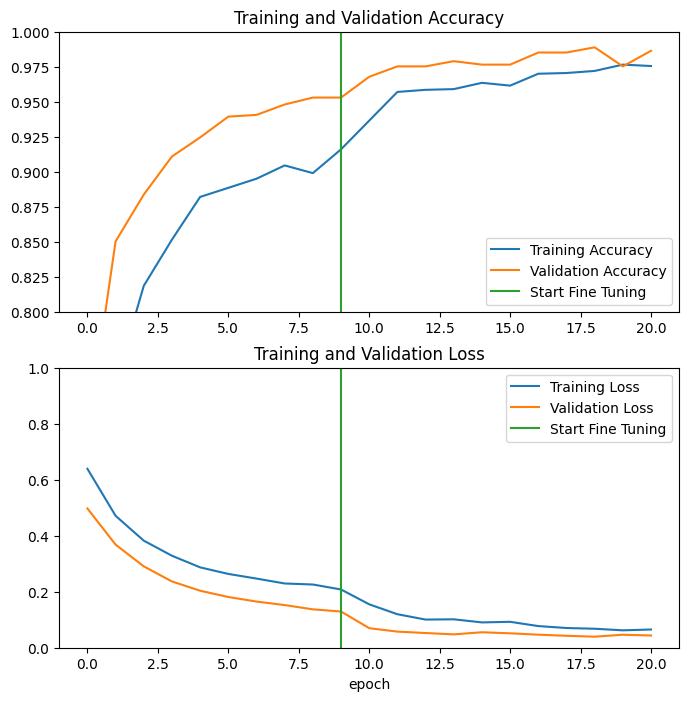

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 评估和预测

最后，您可以使用测试集在新数据上验证模型的性能。

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


1/6 [====>.........................] - ETA: 0s - loss: 0.0175 - accuracy: 1.0000


4/6 [===================>..........] - ETA: 0s - loss: 0.0141 - accuracy: 1.0000


6/6 [==============================] - 0s 24ms/step - loss: 0.0121 - accuracy: 1.0000


Test accuracy : 1.0


现在，您可以使用此模型来预测您的宠物是猫还是狗。

Predictions:
 [0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0]
Labels:
 [0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0]


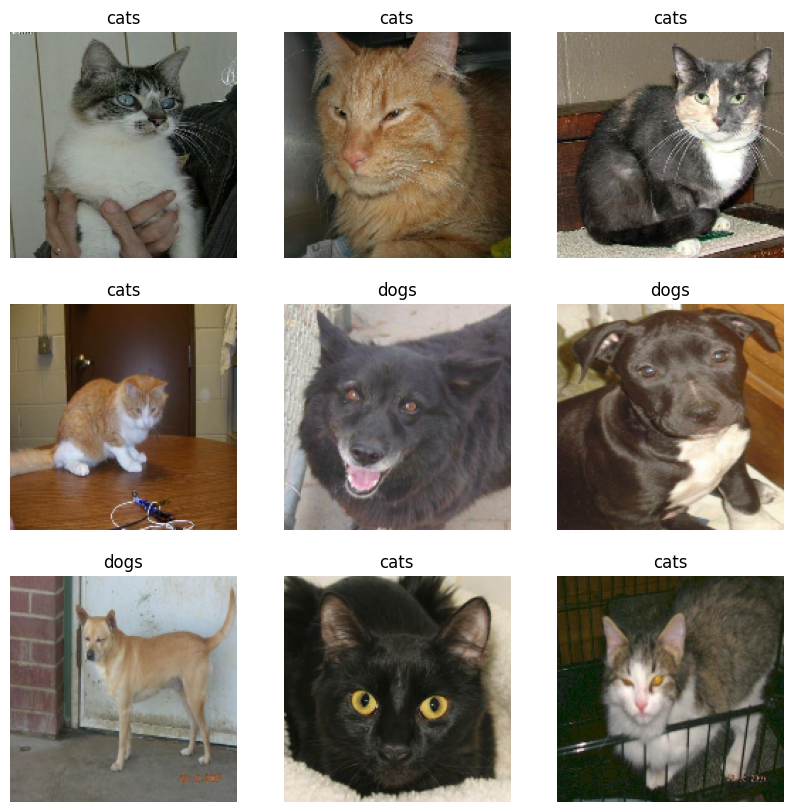

In [37]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## 总结

- **使用预训练模型进行特征提取**：使用小型数据集时，常见做法是利用基于相同域中的较大数据集训练的模型所学习的特征。为此，您需要实例化预训练模型并在顶部添加一个全连接分类器。预训练模型处于“冻结状态”，训练过程中仅更新分类器的权重。在这种情况下，卷积基提取了与每个图像关联的所有特征，而您刚刚训练了一个根据给定的提取特征集确定图像类的分类器。

- **微调预训练模型**：为了进一步提高性能，可能需要通过微调将预训练模型的顶层重新用于新的数据集。在本例中，您调整了权重，以使模型学习特定于数据集的高级特征。当训练数据集较大且与训练预训练模型所使用的原始数据集非常相似时，通常建议使用这种技术。

要了解详情，请参阅[迁移学习指南](https://tensorflow.google.cn/guide/keras/transfer_learning)。
